# step 1

準備四張圖


# step 2

測測






影片的 float 總幀數為: 54.0
影片的 int 總幀數為: 54


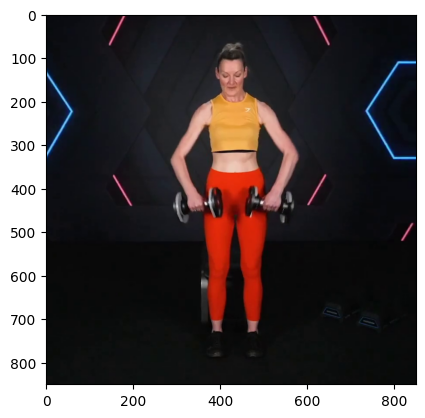

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


model_path = '../utils/models/movenet_t.tflite'
video_path = 'Upright row bilateral dumbbells.mp4'
video_num  = 10

cap = cv2.VideoCapture(video_path)


frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("影片的 float 總幀數為:", frame_count)

frame_count = int(frame_count)
print("影片的 int 總幀數為:", frame_count)


cap.set(cv2.CAP_PROP_POS_FRAMES, video_num)

ret, frame = cap.read()


plt.imshow(frame[:,:,::-1])
plt.show()


cap.release()




In [12]:
from pathlib import Path

path = Path("../utils/models/")

# .stat().st_size
for item in sorted(path.glob("*")):
    
    print(f"name : {item.name},\t size : {item.stat().st_size}, len : {len(item.name)}")


# len(item.name)



name : .DS_Store,	 size : 10244, len : 9
name : BlazePose,	 size : 160, len : 9
name : movenet,	 size : 192, len : 7
name : movenet.tflite,	 size : 4758512, len : 14
name : movenet_multipose_lightning,	 size : 192, len : 27
name : movenet_multipose_lightning_float16.tflite,	 size : 9585276, len : 42
name : movenet_t,	 size : 192, len : 9
name : movenet_t.tflite,	 size : 12584128, len : 16


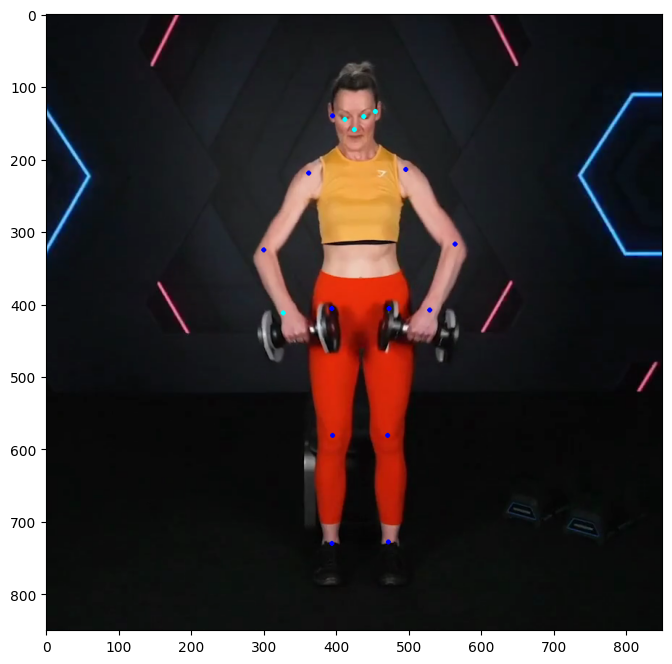

Can't receive frame (stream end?). Exiting ...
count : 54, avg time : 37, fps : 26


In [6]:
#################################################
##  Records 
##  macbook pro intel cpu
##    single_thunder : avg time : 87, fps : 11
##    single_light   : avg time : 29, fps : 33
##    multi_light    : avg time : 81, fps : 12
##  macmini m2 pro cpu
##    single_thunder : avg time : 56, fps : 17
##    single_light   : avg time : 13, fps : 75
##    multi_light    : avg time : 36, fps : 27
## 

import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


video_path  = "Upright row bilateral dumbbells.mp4"
model_index = 2
show_index  = 10
show_flag   = True

model_type_list = [
    "single_thunder",
    "single_light",
    "multi_light"
]
model_type = model_type_list[model_index]

if model_type == "single_thunder":
    model_place = "../utils/models/movenet_t.tflite"
elif model_type == "single_light":
    model_place = "../utils/models/movenet.tflite"
elif model_type == "multi_light":
    model_place = "../utils/models/movenet_multipose_lightning_float16.tflite"


if model_type == "single_thunder" or model_type == "single_light":
    interpreter = tf.lite.Interpreter(model_path=model_place)
    interpreter.allocate_tensors()
    input_details  = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
elif model_type == "multi_light":
    target_size = 256     # 32 倍數

    interpreter = tf.lite.Interpreter(model_path=model_place)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    is_dynamic_shape_model = input_details[0]['shape_signature'][2] == -1
    if is_dynamic_shape_model:
        input_tensor_index = input_details[0]['index']
        input_shape = (1, target_size, target_size, 3)
        interpreter.resize_tensor_input(input_tensor_index, input_shape, strict=True)
    interpreter.allocate_tensors()


cap = cv2.VideoCapture(video_path)

count      = 0
count_time = 0
while(True):
    # 擷取影像
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # frame = cv2.flip(frame, 1)
    
    heigh, width, _ = frame.shape
    # 裁切為正方形
    if heigh < width:
        x = int((width-heigh)/2); y = 0
        w = heigh; h = heigh; width = heigh
        frame = frame[y:y+h, x:x+w]
    elif heigh > width:
        x = 0; y = int((heigh-width)/2)
        w = width; h = width; heigh = width
        frame = frame[y:y+h, x:x+w]

    start_time = time.time()
    
    if model_type == "single_thunder" or model_type == "single_light":
        # thunder 256, light 192
        image = cv2.resize(frame, (input_details[0]['shape'][1], input_details[0]['shape'][1]), interpolation=cv2.INTER_AREA)
        image = tf.expand_dims(image, axis=0)
        interpreter.set_tensor(input_details[0]['index'], tf.cast(image, dtype=tf.uint8).numpy())
        interpreter.invoke()
        target_keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        keypoints_with_scores = target_keypoints_with_scores[0][0]
    elif model_type == "multi_light":
        image_target = cv2.resize(frame, (target_size, target_size), interpolation=cv2.INTER_AREA)[:,:,::-1]
        input_tensor = tf.expand_dims(image_target, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_tensor.numpy())
        interpreter.invoke()
        multi_keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        target_keypoints_with_scores = multi_keypoints_with_scores[0][0]
        keypoints_with_scores = target_keypoints_with_scores[:51].reshape((17,3))
        
    
    # Draw
    if count == show_index and show_flag:
        for keypoint in keypoints_with_scores:
            y_coordinate = int( keypoint[0] * heigh )
            x_coordinate = int( keypoint[1] * width )
            score = keypoint[2]

            if score > 0.8:
                cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,0,0), 2)
            elif score > 0.4:
                cv2.circle(frame, (x_coordinate, y_coordinate), 2, (255,255,0), 2)
            else:
                cv2.circle(frame, (x_coordinate, y_coordinate), 2, (0,0,255), 2)
        
                
        plt.figure(figsize=(8, 8))
        plt.imshow(frame[:,:,::-1])
        plt.show()
    
    
    end_time = time.time()
    count      += 1
    count_time += (end_time - start_time)
    
    # print(f"time : {int((end_time - start_time)*1000)}")

cap.release()
avg_time = count_time / count

print(f"count : {count}, avg time : {int(avg_time * 1000)}, fps : {int(1/avg_time)}")



In [4]:
??tf.lite.Interpreter

Init signature:
tf.lite.Interpreter(
    model_path=None,
    model_content=None,
    experimental_delegates=None,
    num_threads=None,
    experimental_op_resolver_type=<OpResolverType.AUTO: 0>,
    experimental_preserve_all_tensors=False,
    experimental_disable_delegate_clustering=False,
)
Source:        
@_tf_export('lite.Interpreter')
class Interpreter:
  """Interpreter interface for running TensorFlow Lite models.

  Models obtained from `TfLiteConverter` can be run in Python with
  `Interpreter`.

  As an example, lets generate a simple Keras model and convert it to TFLite
  (`TfLiteConverter` also supports other input formats with `from_saved_model`
  and `from_concrete_function`)

  >>> x = np.array([[1.], [2.]])
  >>> y = np.array([[2.], [4.]])
  >>> model = tf.keras.models.Sequential([
  ...           tf.keras.layers.Dropout(0.2),
  ...           tf.keras.layers.Dense(units=1, input_shape=[1])
  ...         ])
  >>> model.compile(optimizer='sgd', loss='mean_squared_error')

In [18]:
keypoints_with_scores

array([[[[0.17982684, 0.5029934 , 0.6494501 ],
         [0.1613132 , 0.5194435 , 0.6722411 ],
         [0.16340235, 0.48997384, 0.7266169 ],
         [0.16055328, 0.5433187 , 0.73934543],
         [0.16322291, 0.4698806 , 0.6325699 ],
         [0.25710005, 0.5868183 , 0.9132134 ],
         [0.26142085, 0.42568013, 0.8980958 ],
         [0.40179276, 0.6008167 , 0.8515651 ],
         [0.40410534, 0.4114371 , 0.8684958 ],
         [0.52396375, 0.5983609 , 0.6875279 ],
         [0.5247931 , 0.41658977, 0.4585995 ],
         [0.4902301 , 0.5559868 , 0.7400591 ],
         [0.49081442, 0.46119064, 0.7617963 ],
         [0.6838794 , 0.5595499 , 0.67822355],
         [0.68827015, 0.46372408, 0.62586707],
         [0.8578693 , 0.55919516, 0.84467506],
         [0.865706  , 0.46008757, 0.57276785]]]], dtype=float32)

In [16]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 316,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

下面是一個簡單的範例，假設你有一個名為 video.mp4 的影片檔案，你可以用以下的程式碼來獲取它的總幀數：

```python
import cv2

# 建立一個 VideoCapture 物件，並傳入影片檔案的路徑
cap = cv2.VideoCapture("video.mp4")

# 使用 get 方法，並傳入 cv2.CAP_PROP_FRAME_COUNT 參數，獲取影片的總幀數
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# 將浮點數轉換成整數
frame_count = int(frame_count)

# 顯示結果
print("影片的總幀數為:", frame_count)

# 釋放資源
cap.release()
```


下面是一個簡單的範例，假設你有一個名為 video.mp4 的影片檔案，你想要讀取第 100 幀的圖片，你可以用以下的程式碼來實現：

```python
import cv2

# 建立一個 VideoCapture 物件，並傳入影片檔案的路徑
cap = cv2.VideoCapture("video.mp4")

# 使用 set 方法，並傳入 cv2.CAP_PROP_POS_FRAMES 和目標幀數，將影片定位到指定的幀
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)

# 使用 read 方法，讀取該幀的圖片
ret, frame = cap.read()

# 顯示圖片
cv2.imshow("Frame 100", frame)

# 等待按鍵
cv2.waitKey(0)

# 釋放資源
cap.release()
cv2.destroyAllWindows()
```


In [3]:


# 720/1280, 1080/1920
# 720 = 2^4 * 3^2 * 5
# 1080 = 2^3 * 3^3 * 5
display_rate = 3/2 # or 1




1.0

In [54]:
255*2 / 20

25.5

In [52]:
import numpy as np
from queue import Queue

q = Queue(maxsize = 3)

q.put(0.1)
q.put(0.9)
print(q.full())
q.put(0.2)
q.get()
q.put(0.8)

print(np.array(q.queue))
np.array(q.queue).mean()




False
[0.9 0.2 0.8]


0.6333333333333334